<a href="https://colab.research.google.com/github/miketech-traces/fynesse_mlfc/blob/main/Agriculture_Productivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression pipeline for Kenya county-level agricultural productivity (yield).

# Data sources:

KNBS/NIPFN (maize county production). :contentReference[oaicite:6]{index=6}

KNBS population files (2019 census). :contentReference[oaicite:7]{index=7}

KilimoSTAT bulk crops API/downloads. :contentReference[oaicite:8]{index=8}

CHIRPS (rainfall). :contentReference[oaicite:9]{index=9}

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import statsmodels.api as sm
import seaborn as sns

#Loading Data

In [10]:
maize_df = pd.read_excel('Maize-Production-2012-2020-Combined.xlsx')  # should have County, Year, Production_Tons, Area_Ha
population_df = pd.read_csv('2019-population_census-report-per-county.csv')  # County, Population, Land_Area_km2
agricultural_production_df = pd.read_excel('Kenyas_Agricultural_Production.xlsx')

In [22]:
maize_df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,NaN,2012,NaN,NaN,2013,NaN,NaN,2014,NaN,NaN,...,NaN,2017,NaN,NaN,2018,NaN,NaN,2020,NaN,NaN
1,COUNTY,Harvested Area (HA),Production (MT),Yield (MT/HA),Harvested Area (HA),Production (MT),Yield (MT/HA),Harvested Area (HA),Production (MT),Yield (MT/HA),...,Yield (MT/HA),Area (HA) 2017,Production (MT) 2017,Yield(MT/HA),Area Ha 2018,Quantity Ton 2018,Yield(MT/HA),Area (Ha) 2020,Production (MT) 2020,Yield (MT/HA)
2,Baringo,39753,71866.62,1.807829,29117,55805.04,1.916579,34960,34959,0.999971,...,2.186021,33308,45764,1.373964,37658,58475.6,1.552807,47437,68374.39,1.441373
3,Bomet,32697,73277.82,2.241118,30620,72235.8,2.359105,30940,53162,1.718229,...,1.410287,33792,56601,1.674982,33291,58336.81,1.75233,38163,73609.65,1.928822
4,Bungoma,96209,262381.05,2.727199,92705,221586.03,2.390227,98074,267302,2.725513,...,2.989396,95323,289290,3.034839,93484,295481.1,3.160767,87960,317912.33,3.614283


In [23]:
population_df.head()

,County,Total_Population19,Male populatio 2019,Female population 2019,Households,Av_HH_Size,LandArea,Population Density,Population in 2009,Pop_change,Intersex population 2019
0,Baringo,"666,763","336,322","330,428","142,518",5,"10,976",61,"555,561","111,202",13
1,Bomet,"875,689","434,287","441,379","187,641",5,"2,531",346,"724,186","151,503",23
2,Bungoma,"1,670,570","812,146","858,389","358,796",5,"3,024",552,"1,630,934","39,636",35
3,Busia,"893,681","426,252","467,401","198,152",5,"1,696",527,"488,075","405,606",28
4,Elgeyo-Marakwet,"454,480","227,317","227,151","99,861",5,"3,032",150,"369,998","84,482",12


In [32]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   County                    47 non-null     object
 1   Total_Population19        47 non-null     object
 2   Male populatio 2019       47 non-null     object
 3   Female population 2019    47 non-null     object
 4   Households                47 non-null     object
 5   Av_HH_Size                47 non-null     int64 
 6   LandArea                  47 non-null     object
 7   Population Density        47 non-null     object
 8   Population in 2009        47 non-null     object
 9   Pop_change                47 non-null     object
 10  Intersex population 2019  47 non-null     int64 
dtypes: int64(2), object(9)
memory usage: 4.2+ KB


In [105]:
population_df.describe()

,Total_Population19,Av_HH_Size,LandArea,Intersex population 2019,Year
count,4.700000e+01,47.000000,47.00000,47.000000,47.0
mean,1.012007e+06,4.340426,12359.06383,32.425532,2019.0
std,6.932424e+05,0.938931,17366.01343,38.490961,0.0
min,1.439200e+05,3.000000,220.00000,2.000000,2019.0
25%,6.095050e+05,4.000000,2530.50000,18.000000,2019.0
50%,8.936810e+05,4.000000,3325.00000,25.000000,2019.0
75%,1.156724e+06,5.000000,14846.00000,34.000000,2019.0
max,4.397073e+06,7.000000,70944.00000,245.000000,2019.0


In [106]:
maize_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   48 non-null     object
 1   Unnamed: 1   49 non-null     object
 2   Unnamed: 2   48 non-null     object
 3   Unnamed: 3   48 non-null     object
 4   Unnamed: 4   49 non-null     object
 5   Unnamed: 5   48 non-null     object
 6   Unnamed: 6   48 non-null     object
 7   Unnamed: 7   49 non-null     object
 8   Unnamed: 8   48 non-null     object
 9   Unnamed: 9   48 non-null     object
 10  Unnamed: 10  49 non-null     object
 11  Unnamed: 11  48 non-null     object
 12  Unnamed: 12  48 non-null     object
 13  Unnamed: 13  49 non-null     object
 14  Unnamed: 14  48 non-null     object
 15  Unnamed: 15  48 non-null     object
 16  Unnamed: 16  49 non-null     object
 17  Unnamed: 17  48 non-null     object
 18  Unnamed: 18  48 non-null     object
 19  Unnamed: 19  49 non-null     ob

In [107]:
maize_df.describe()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
count,48,49,48,48,49,48,48,49,48,48,...,48,49,48,48,49,48,48,49,48,48
unique,48,49,48,48,48,48,48,46,48,48,...,48,49,48,48,49,48,48,49,48,48
top,COUNTY,2012,Production (MT),Yield (MT/HA),61416,Production (MT),Yield (MT/HA),653,Production (MT),Yield (MT/HA),...,Yield (MT/HA),2017,Production (MT) 2017,Yield(MT/HA),2018,Quantity Ton 2018,Yield(MT/HA),2020,Production (MT) 2020,Yield (MT/HA)
freq,1,1,1,1,2,1,1,3,1,1,...,1,1,1,1,1,1,1,1,1,1


# Basic cleaning & feature engineering

In [37]:
# Add a 'Year' column to the population DataFrame for merging
population_df['Year'] = 2019

# Clean and convert population and land area columns to numeric in population_df
population_df['Total_Population19'] = population_df['Total_Population19'].astype(str).str.replace(',', '', regex=False).astype(int)
population_df['LandArea'] = population_df['LandArea'].astype(str).str.replace(',', '', regex=False).astype(float)

# Check the counties in both dataframes before merging
print("Counties in maize_pivot_df (2019):")
display(maize_pivot_df[maize_pivot_df['Year'] == 2019]['County'].unique())

print("\nCounties in population_df:")
display(population_df['County'].unique())

# Check if there is any maize data for the year 2019
print("\nNumber of rows in maize_pivot_df for Year 2019:", len(maize_pivot_df[maize_pivot_df['Year'] == 2019]))


# Merge maize production data with population data for the year 2019
merged_df = pd.merge(maize_pivot_df[maize_pivot_df['Year'] == 2019],
                     population_df[['County', 'Year', 'Total_Population19', 'LandArea']],
                     on=['County', 'Year'],
                     how='left')

# Display the merged DataFrame
print("\nMerged Maize and Population Data (2019):")
display(merged_df.head())

Counties in maize_pivot_df (2019):


array([], dtype=object)


Counties in population_df:


array(['Baringo', 'Bomet', 'Bungoma', 'Busia', 'Elgeyo-Marakwet', 'Embu',
       'Garissa', 'Homa Bay', 'Isiolo', 'Kajiado', 'Kakamega', 'Kericho',
       'Kiambu', 'Kilifi', 'Kirinyaga', 'Kisii', 'Kisumu', 'Kitui',
       'Kwale', 'Laikipia', 'Lamu', 'Machakos', 'Makueni', 'Mandera',
       'Marsabit', 'Meru', 'Migori', 'Mombasa', "Murang'a", 'Nairobi',
       'Nakuru', 'Nandi', 'Narok', 'Nyamira', 'Nyandarua', 'Nyeri',
       'Samburu', 'Siaya', 'Taita Taveta', 'Tana River', 'Tharaka-Nithi',
       'Trans Nzoia', 'Turkana', 'Uasin Gishu', 'Vihiga', 'Wajir',
       'West Pokot'], dtype=object)


Number of rows in maize_pivot_df for Year 2019: 0

Merged Maize and Population Data (2019):


,County,Year,Total_Population19,LandArea


In [44]:
# Add a 'Year' column to the population DataFrame for merging
population_df['Year'] = 2019

# Clean and convert population and land area columns to numeric in population_df
population_df['Total_Population19'] = population_df['Total_Population19'].astype(str).str.replace(',', '', regex=False).astype(int)
population_df['LandArea'] = population_df['LandArea'].astype(str).str.replace(',', '', regex=False).astype(float)

# Check the counties in both dataframes before merging
print("Counties in maize_pivot_df (2019):")
display(maize_pivot_df[maize_pivot_df['Year'] == 2019]['County'].unique())

print("\nCounties in population_df:")
display(population_df['County'].unique())

# Check if there is any maize data for the year 2019
print("\nNumber of rows in maize_pivot_df for Year 2019:", len(maize_pivot_df[maize_pivot_df['Year'] == 2019]))


# Merge maize production data with population data for the year 2019
merged_df = pd.merge(maize_pivot_df[maize_pivot_df['Year'] == 2019],
                     population_df[['County', 'Year', 'Total_Population19', 'LandArea']],
                     on=['County', 'Year'],
                     how='left')

# Display the merged DataFrame
print("\nMerged Maize and Population Data (2019):")
display(merged_df.head())

Counties in maize_pivot_df (2019):


array([], dtype=object)


Counties in population_df:


array(['Baringo', 'Bomet', 'Bungoma', 'Busia', 'Elgeyo-Marakwet', 'Embu',
       'Garissa', 'Homa Bay', 'Isiolo', 'Kajiado', 'Kakamega', 'Kericho',
       'Kiambu', 'Kilifi', 'Kirinyaga', 'Kisii', 'Kisumu', 'Kitui',
       'Kwale', 'Laikipia', 'Lamu', 'Machakos', 'Makueni', 'Mandera',
       'Marsabit', 'Meru', 'Migori', 'Mombasa', "Murang'a", 'Nairobi',
       'Nakuru', 'Nandi', 'Narok', 'Nyamira', 'Nyandarua', 'Nyeri',
       'Samburu', 'Siaya', 'Taita Taveta', 'Tana River', 'Tharaka-Nithi',
       'Trans Nzoia', 'Turkana', 'Uasin Gishu', 'Vihiga', 'Wajir',
       'West Pokot'], dtype=object)


Number of rows in maize_pivot_df for Year 2019: 0

Merged Maize and Population Data (2019):


,County,Year,Harvested_Area_Ha,Production_Tons,Total_Population19,LandArea


In [53]:
# Clean and convert population and land area columns to numeric in population_df (ensure this is done)
population_df['Total_Population19'] = population_df['Total_Population19'].astype(str).str.replace(',', '', regex=False).astype(int)
population_df['LandArea'] = population_df['LandArea'].astype(str).str.replace(',', '', regex=False).astype(float)

# Merge maize production data with population data based on County
# We will keep all years from maize_pivot_df and add the 2019 population data
merged_df = pd.merge(maize_pivot_df,
                     population_df[['County', 'Total_Population19', 'LandArea']],
                     on='County',
                     how='left')

# Display the merged DataFrame
print("Merged Maize and Population Data:")
display(merged_df.head())

# Check for missing values after merge
print("\nMissing values after merge:")
display(merged_df.isnull().sum())

Merged Maize and Population Data:


,County,Year,Harvested_Area_Ha,Production_Tons,Yield_t_per_ha,Total_Population19,LandArea
0,Baringo,2012.0,39753.0,NaN,NaN,666763.0,10976.0
1,Baringo,2013.0,29117.0,NaN,NaN,666763.0,10976.0
2,Baringo,2014.0,34960.0,NaN,NaN,666763.0,10976.0
3,Baringo,2015.0,44159.0,NaN,NaN,666763.0,10976.0
4,Baringo,2016.0,33163.0,NaN,NaN,666763.0,10976.0



Missing values after merge:


,0
County,0
Year,0
Harvested_Area_Ha,0
Production_Tons,235
Yield_t_per_ha,236
Total_Population19,40
LandArea,40


In [63]:
# Create new features: Yield per capita and Harvested Area per capita
# Add a small value to population to avoid division by zero if any county has zero population
df_cleaned_complete['Yield_per_capita'] = df_cleaned_complete['Yield_t_per_ha'] / (df_cleaned_complete['Total_Population19'] + 1e-6)
df_cleaned_complete['Harvested_Area_per_capita'] = df_cleaned_complete['Harvested_Area_Ha'] / (df_cleaned_complete['Total_Population19'] + 1e-6)

# Display the head of the DataFrame with new features
print("DataFrame with new engineered features:")
display(df_cleaned_complete.head())

DataFrame with new engineered features:


,County,Year,Harvested_Area_Ha,Production_Tons,Yield_t_per_ha,Total_Population19,LandArea,Yield_per_capita,Harvested_Area_per_capita
5,Baringo,2017.0,33308.0,45764.00,1.373964,666763.0,10976.0,0.000002,0.049955
6,Baringo,2018.0,37658.0,58475.60,1.552807,666763.0,10976.0,0.000002,0.056479
7,Baringo,2020.0,47437.0,68374.39,1.441373,666763.0,10976.0,0.000002,0.071145
13,Bomet,2017.0,33792.0,56601.00,1.674982,875689.0,2531.0,0.000002,0.038589
14,Bomet,2018.0,33291.0,58336.81,1.752330,875689.0,2531.0,0.000002,0.038017


In [70]:
# Drop rows with remaining missing values in 'Total_Population19' and 'LandArea'
df_cleaned_complete = df_cleaned.dropna(subset=['Total_Population19', 'LandArea']).copy()

print("Shape of data after dropping all remaining missing values:", df_cleaned_complete.shape)

# Check for remaining missing values
print("\nRemaining missing values after dropping all remaining missing values:")
display(df_cleaned_complete.isnull().sum())

Shape of data after dropping all remaining missing values: (126, 7)

Remaining missing values after dropping all remaining missing values:


,0
County,0
Year,0
Harvested_Area_Ha,0
Production_Tons,0
Yield_t_per_ha,0
Total_Population19,0
LandArea,0


## Exploratory Data Analysis

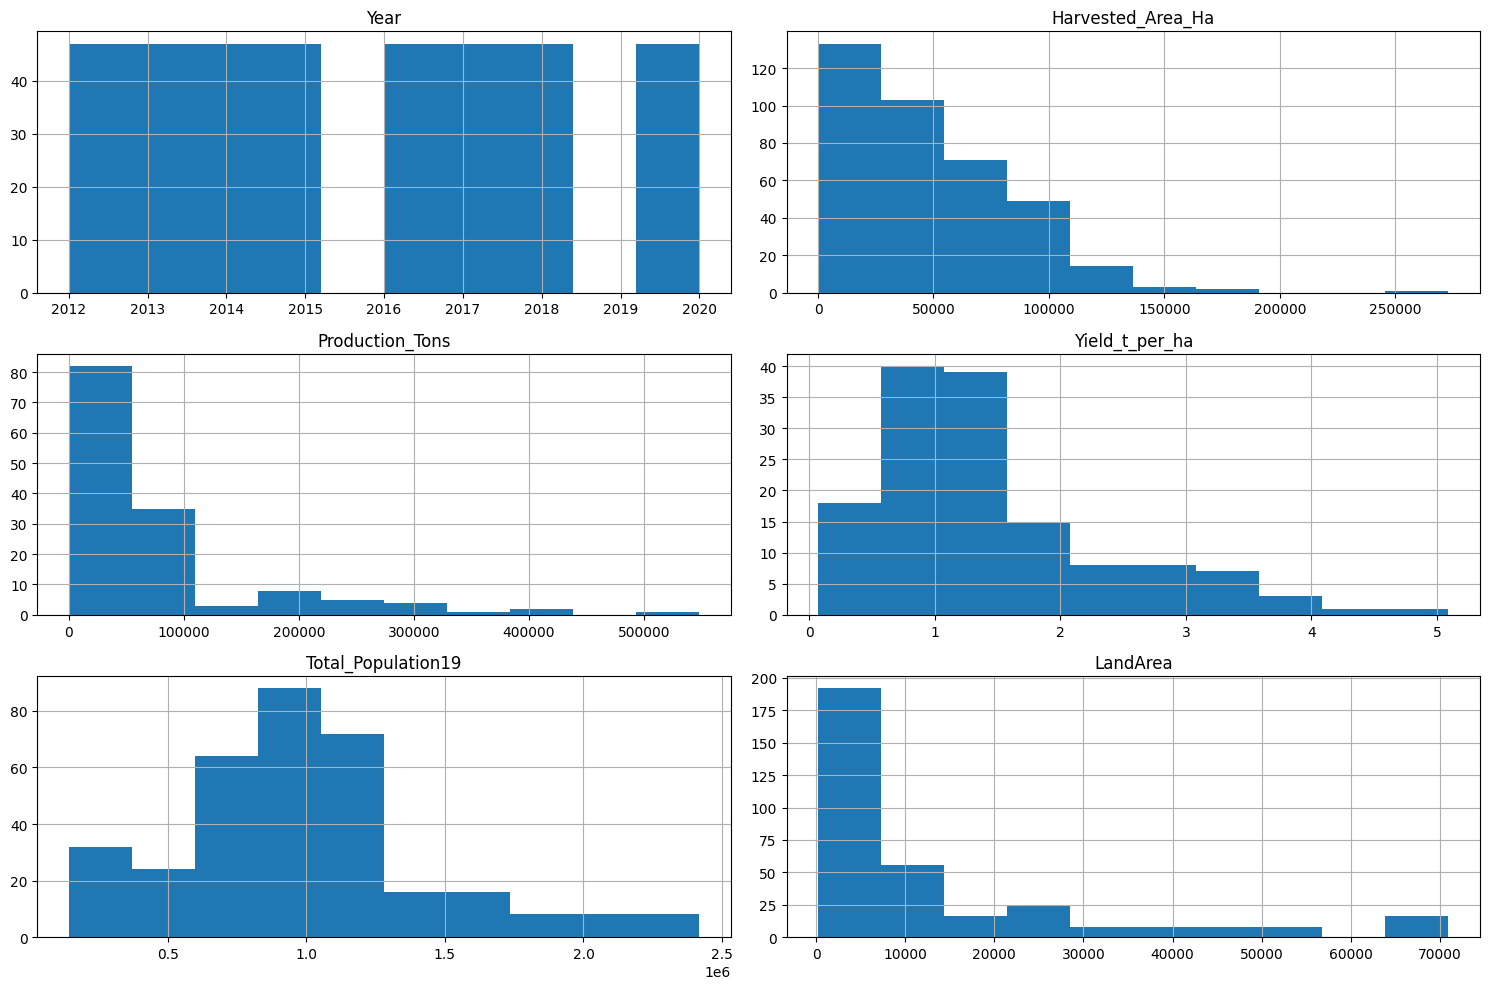

In [55]:
# Visualize the distributions of numerical features
merged_df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

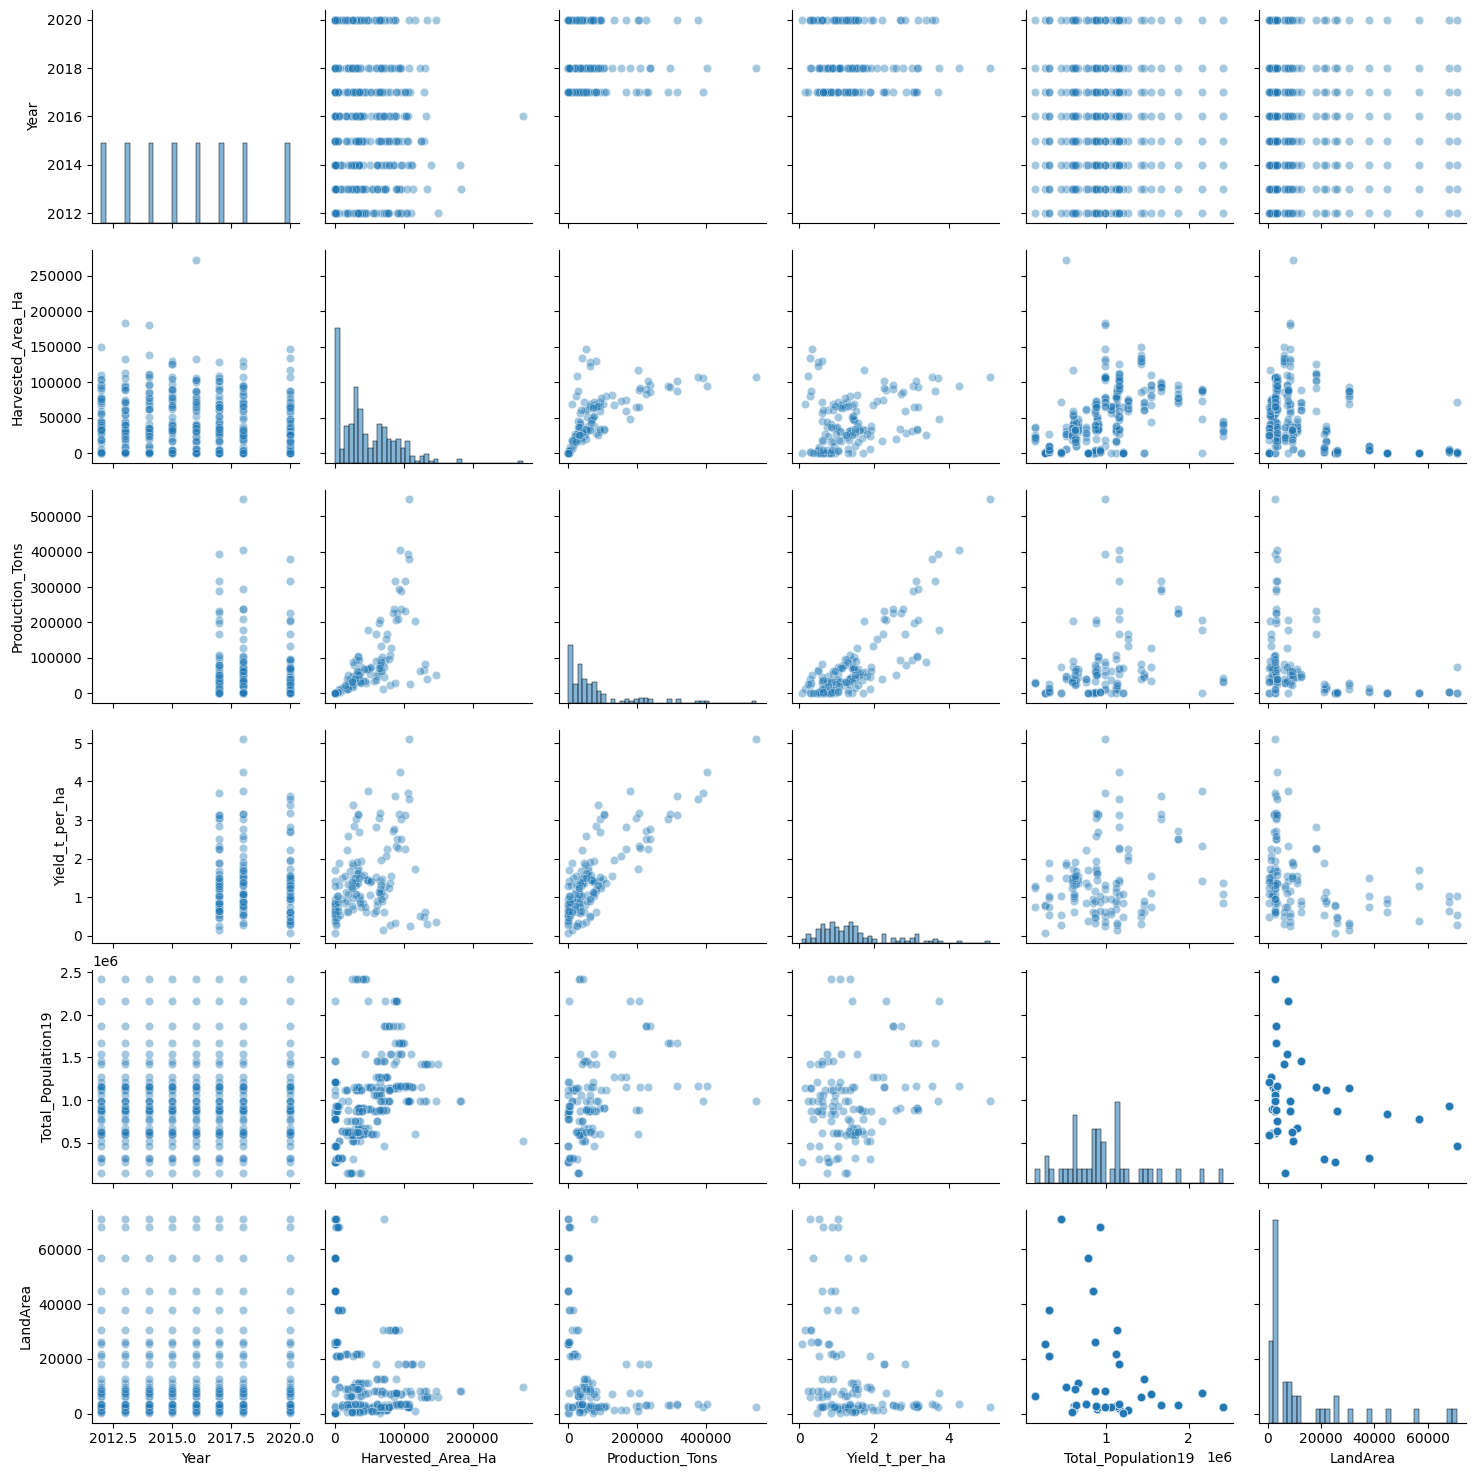

In [99]:
sns.pairplot(merged_df,
             kind='scatter',
             plot_kws={'alpha':0.4},
             diag_kws={'alpha':0.55, 'bins':40})

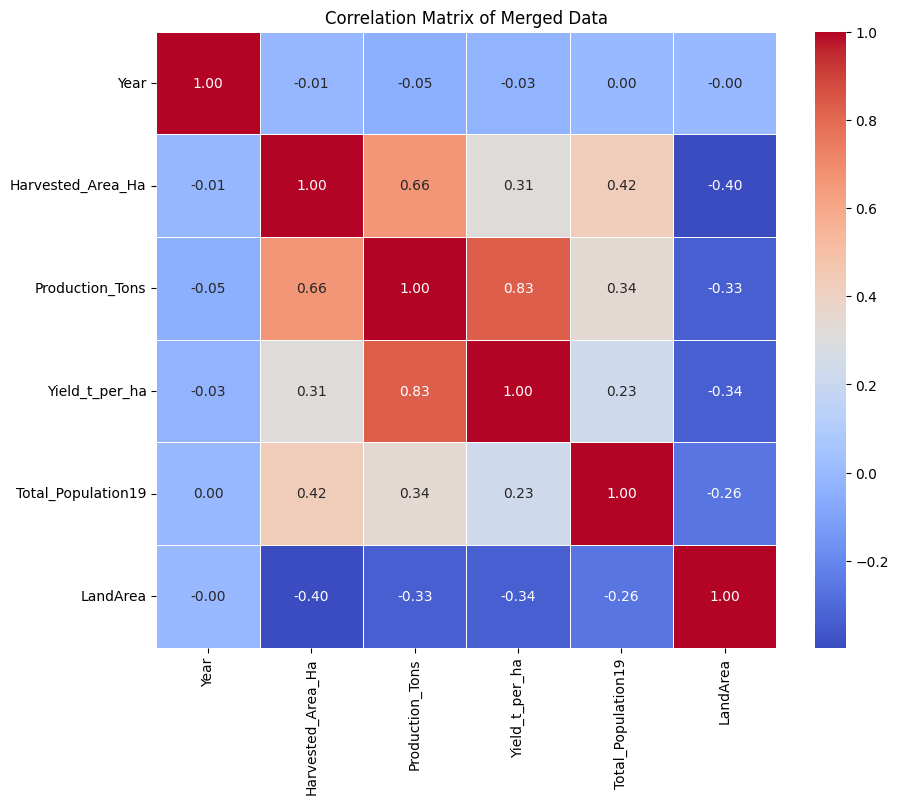

In [56]:
# Calculate the correlation matrix
correlation_matrix = merged_df.corr(numeric_only=True)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Merged Data')
plt.show()

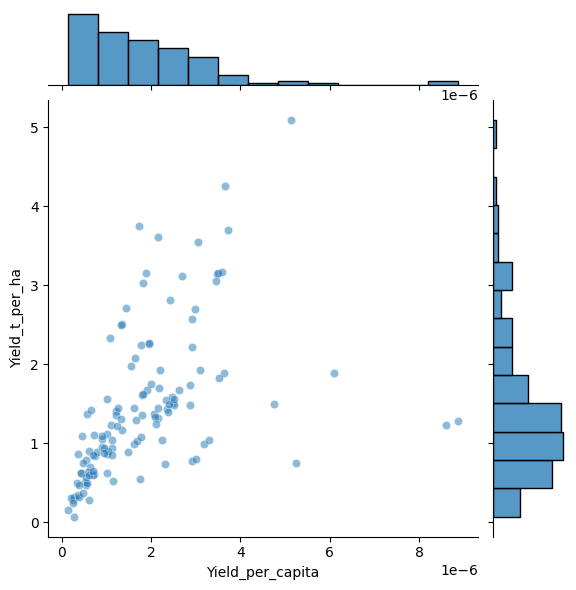

In [103]:
# Original Yield vs Yield per Capita
sns.jointplot(x='Yield_per_capita', y='Yield_t_per_ha', data=df_cleaned_complete, alpha=0.5)


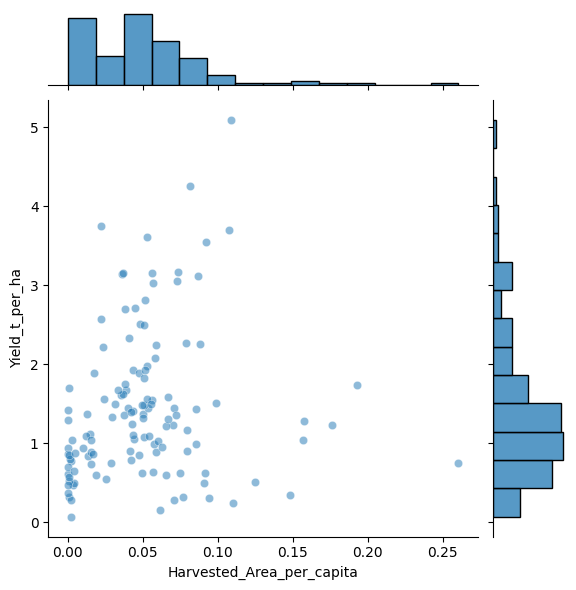

In [104]:
# Scatter plot: Yield vs Harvested Area per capita
sns.jointplot(x='Harvested_Area_per_capita', y='Yield_t_per_ha', data=df_cleaned_complete, alpha=0.5)

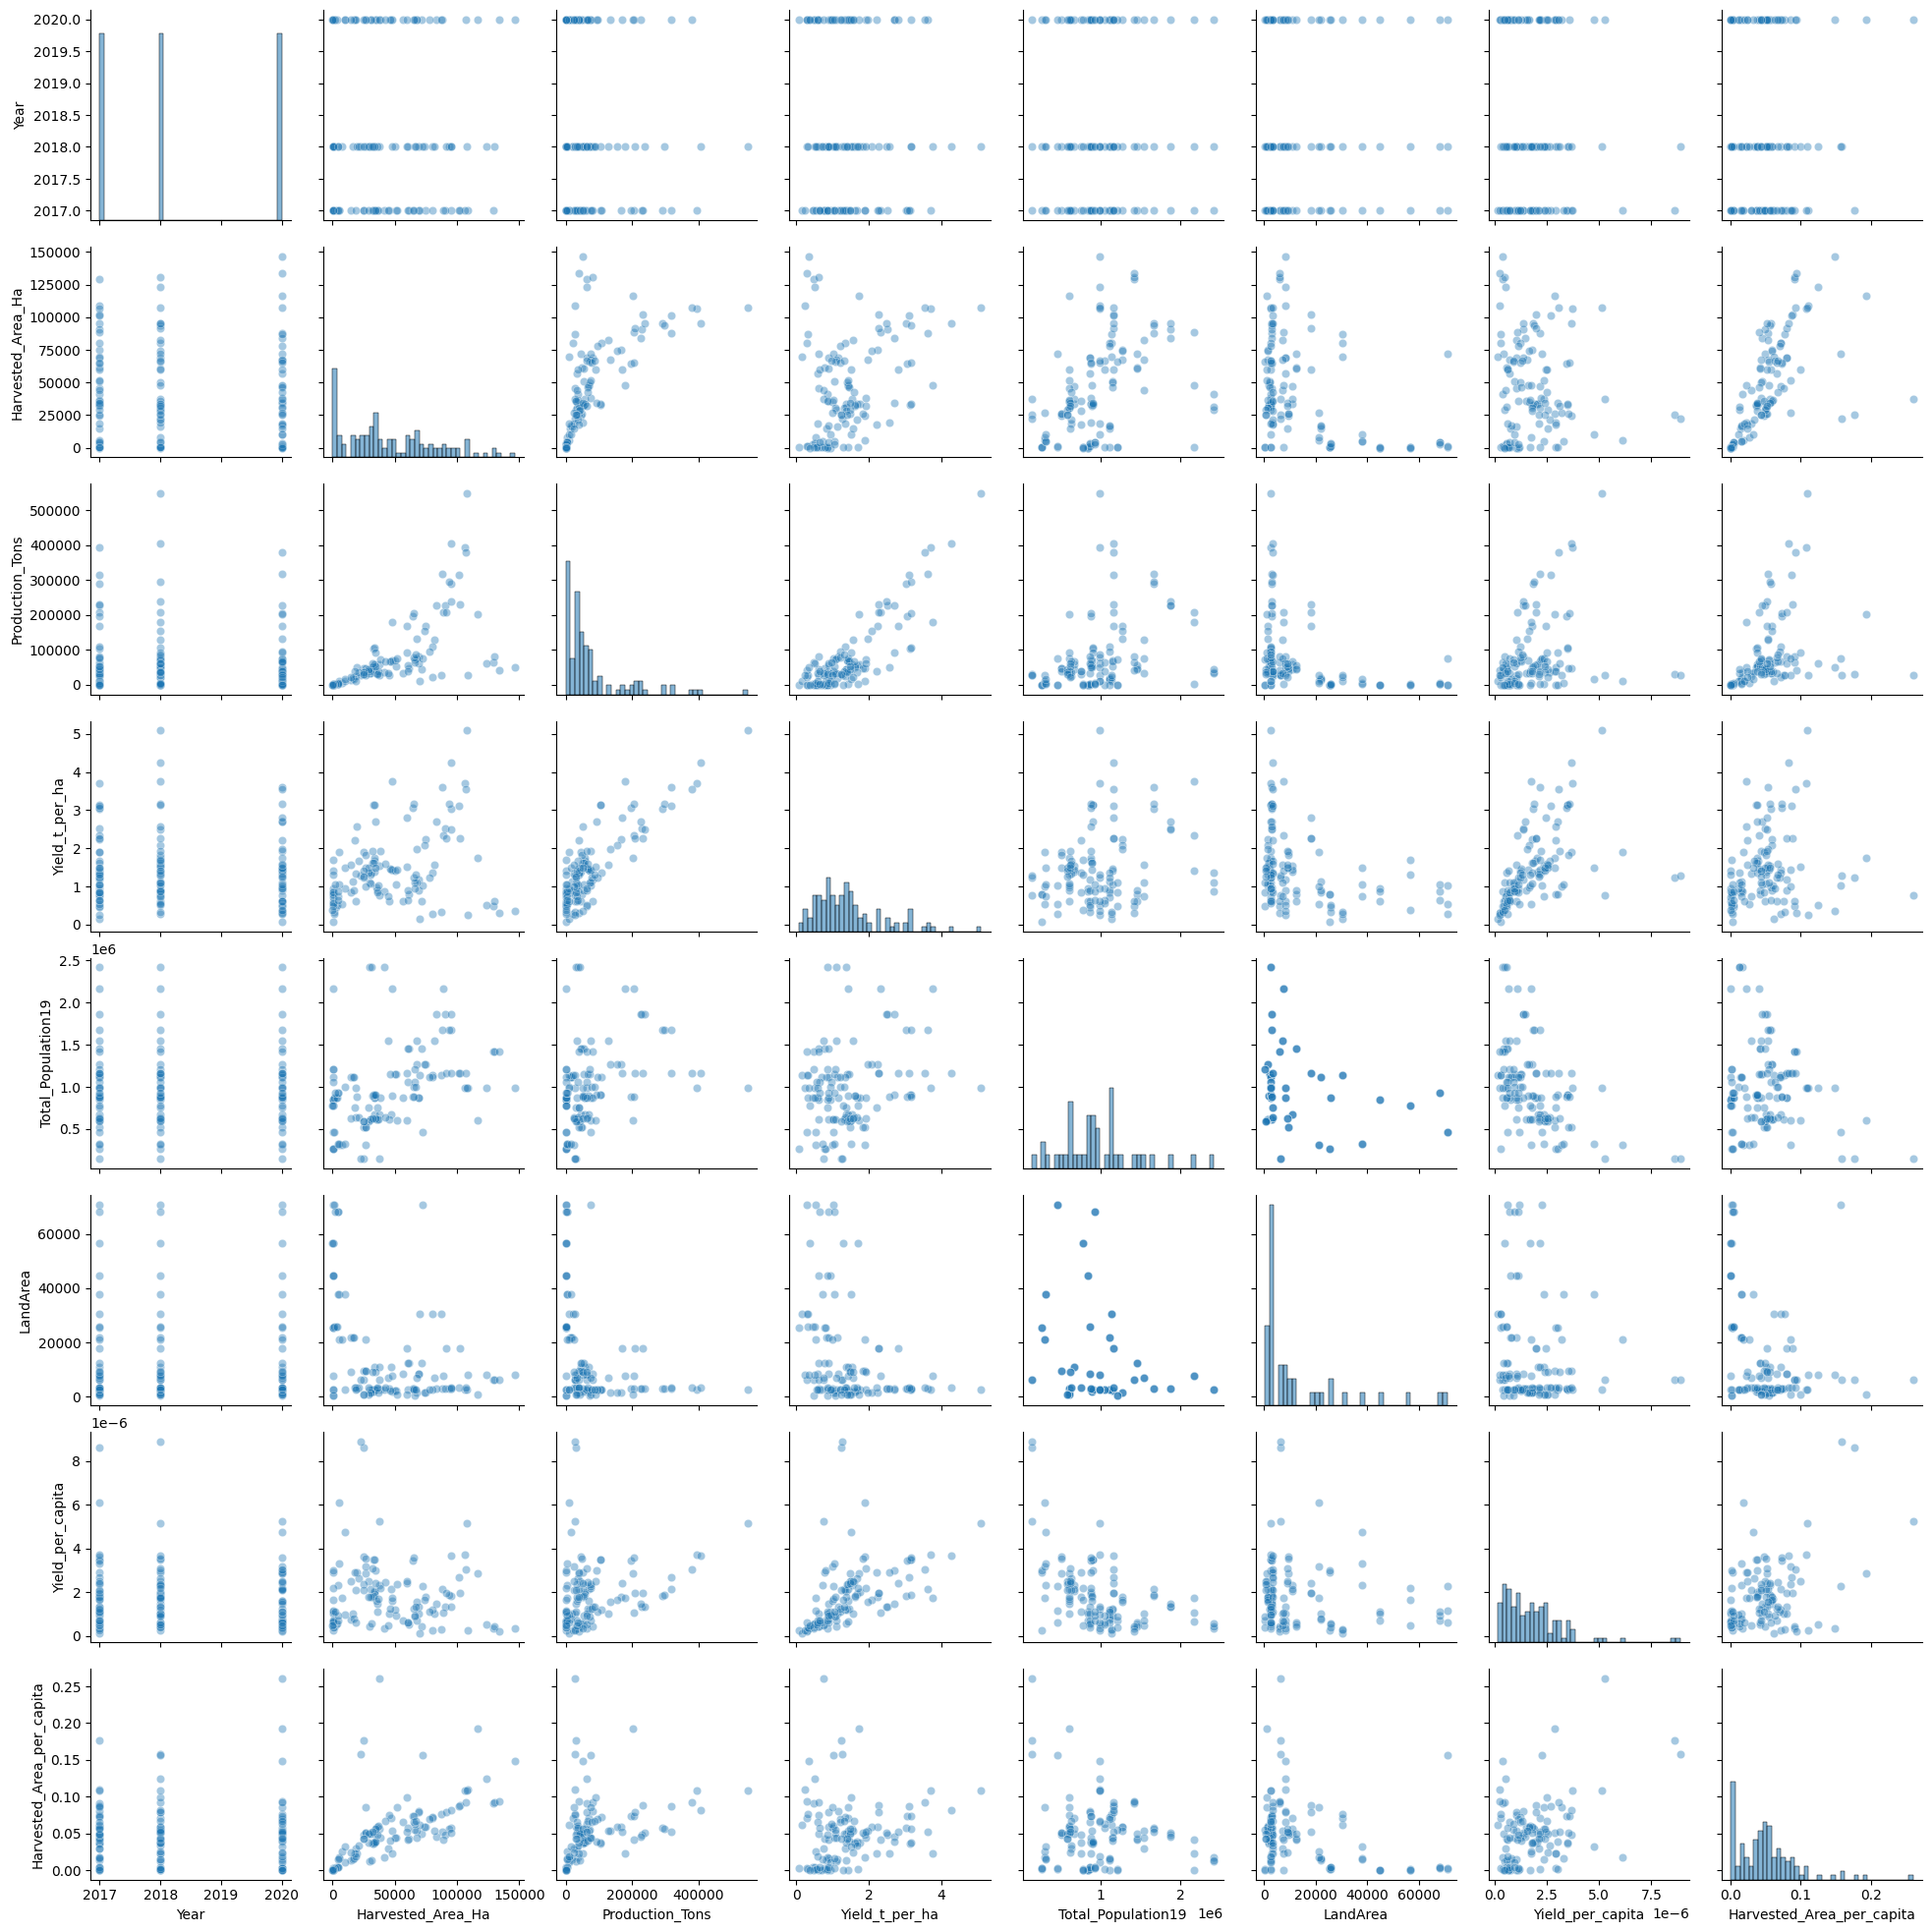

In [98]:
sns.pairplot(df_cleaned_complete,
             kind='scatter',
             plot_kws={'alpha':0.4},
             diag_kws={'alpha':0.55, 'bins':40})

# Splitting the data

X are the predictores, and y is the output. What we want to do is create a model that will take in the values in the X variable and predict y with a linear regression algorithm. We will use the SciKit Learn library to create the model.

In [69]:
from sklearn.model_selection import train_test_split

In [71]:
df_cleaned_complete.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 5 to 375
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   County              126 non-null    object 
 1   Year                126 non-null    float64
 2   Harvested_Area_Ha   126 non-null    float64
 3   Production_Tons     126 non-null    float64
 4   Yield_t_per_ha      126 non-null    float64
 5   Total_Population19  126 non-null    float64
 6   LandArea            126 non-null    float64
dtypes: float64(6), object(1)
memory usage: 7.9+ KB


In [77]:
# Create new features: Yield per capita and Harvested Area per capita
# Add a small value to population to avoid division by zero if any county has zero population
df_cleaned_complete['Yield_per_capita'] = df_cleaned_complete['Yield_t_per_ha'] / (df_cleaned_complete['Total_Population19'] + 1e-6)
df_cleaned_complete['Harvested_Area_per_capita'] = df_cleaned_complete['Harvested_Area_Ha'] / (df_cleaned_complete['Total_Population19'] + 1e-6)

# Select features (X) and target variable (y)
X = df_cleaned_complete[['Harvested_Area_Ha', 'Total_Population19', 'LandArea', 'Yield_per_capita', 'Harvested_Area_per_capita']]
y = df_cleaned_complete['Yield_t_per_ha']

In [78]:
X.head()
y.head()

,Yield_t_per_ha
5,1.373964
6,1.552807
7,1.441373
13,1.674982
14,1.752330


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [83]:

# Display the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (88, 5)
Shape of X_test: (38, 5)
Shape of y_train: (88,)
Shape of y_test: (38,)


# Training the Model with multivariable regression using Scikit Learn

In this section, we create the model and feed the training data to it. This model will tell us which input has the biggest impact in the output (yearly expenditure). As the plots suggested, we find that the most important coefficient is that of the "Length of Membership" predictor, followed by the 'Time on App' and the 'Avg. Session Length'. The time on website does not seem to be an important factor to the amount a customer spends per year.

In [80]:
from sklearn.linear_model import LinearRegression

In [81]:
lm = LinearRegression()

In [82]:
lm.fit(X_train, y_train)

LinearRegression()

In [84]:
# the coefficients
lm.coef_

array([ 2.06921838e-05,  4.73302051e-07, -6.55691082e-06,  6.63903067e+05,
       -2.01038239e+01])

In [85]:
# r squared
lm.score(X, y)

0.6541933180143011

In [86]:
# The coefficients in a dataframe
cdf = pd.DataFrame(lm.coef_,X.columns,columns=['Coef'])
print(cdf)

                                   Coef
Harvested_Area_Ha          2.069218e-05
Total_Population19         4.733021e-07
LandArea                  -6.556911e-06
Yield_per_capita           6.639031e+05
Harvested_Area_per_capita -2.010382e+01


# Training the model with multivariable regression using OLS

Allows us to get more details about the model

In [87]:
import statsmodels.api as sm

X = sm.add_constant(X_train)
model = sm.OLS(y_train, X)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         Yield_t_per_ha   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     37.33
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           8.99e-20
Time:                        10:02:33   Log-Likelihood:                -65.810
No. Observations:                  88   AIC:                             143.6
Df Residuals:                      82   BIC:                             158.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

# Predicting Test Data
Now that the model is trained, we should be able to use it to make our predictions and evaluate our model. The scatter plot below plots the actual y values to the model's predictions. The model seems to behave accurately.

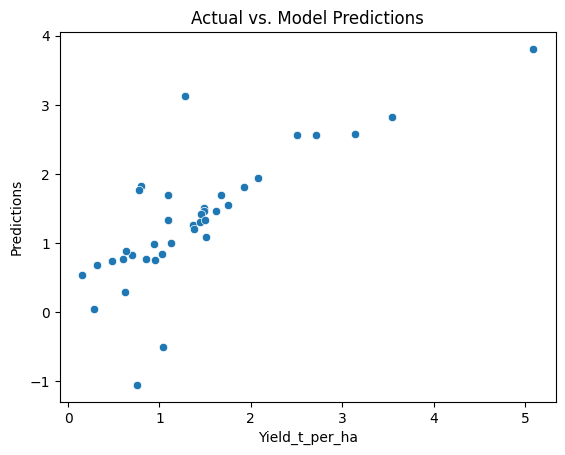

In [89]:
# Make predictions on the test data
y_pred = lm.predict(X_test)

# Scatter plot of actual values of y vs predicted values.
sns.scatterplot(x=y_test, y=y_pred)
plt.ylabel('Predictions')
plt.title('Actual vs. Model Predictions') # Changed title for clarity
plt.show() # Ensure plot is displayed

# Evaluation of the model

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [92]:
print('Mean Absolute Error:',mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:',mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:',math.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.40258515956338725
Mean Squared Error: 0.3975927946874889
Root Mean Squared Error: 0.63054959732561


# Residuals

Distribution plot of the residuals of the model's predictions. They should be normally distributed.

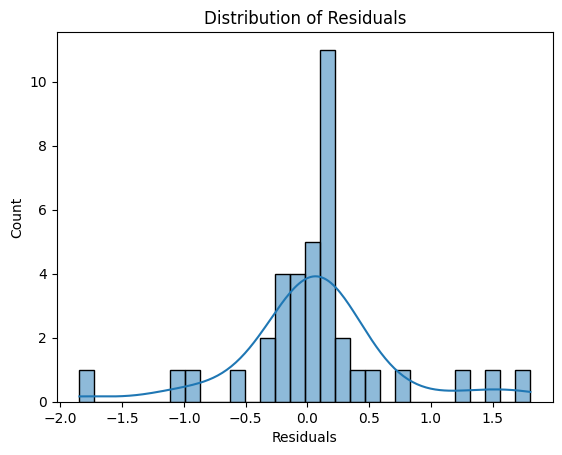

In [96]:
residuals = y_test-y_pred
sns.histplot(residuals, bins=30, kde=True) # Use histplot and add kde for a smoothed line
plt.xlabel('Residuals') # Add x-label for clarity
plt.title('Distribution of Residuals') # Add title for clarity
plt.show() # Ensure the plot is displayed

/tmp/ipython-input-2722698825.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30)


<Axes: xlabel='Yield_t_per_ha', ylabel='Density'>

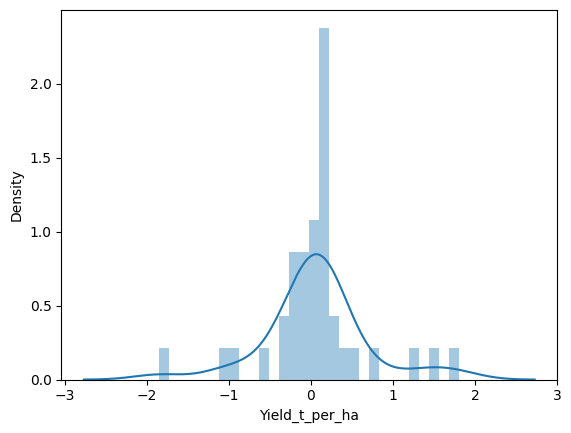

In [97]:
residuals = y_test-y_pred
sns.distplot(residuals, bins=30)

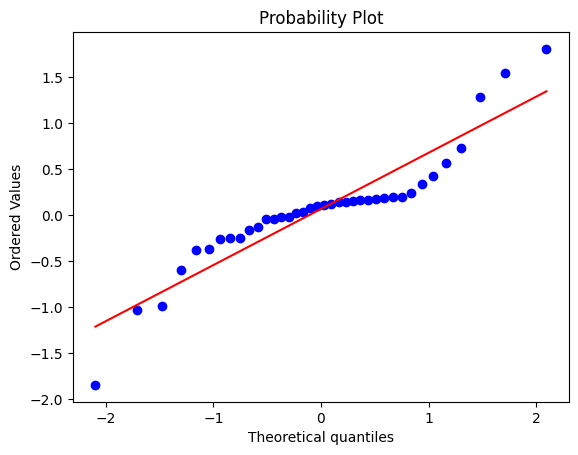

In [95]:
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()